# Income Analysis

## Packages & Libraries

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from evaluation_utils import evaluate_with_cv, evaluate_on_holdout, results_summary
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, average_precision_score, precision_score, average_precision_score, recall_score, f1_score, precision_recall_curve


import warnings
warnings.filterwarnings('ignore')
results_summary.clear()

## Analysing the dataset

### Insights

- There are a total of 13 features and additional weights have been given to compensate for the selection bias.
- The target variable is binary with classes as income <=50k or >50k.
- The data has some missing values in categorical features.
- Though the complete dataset is 30000 instances, only 5000 instances were available for training.

In [97]:
file_path = '../data/einkommen.train'

data = []

with open(file_path, 'r') as file:
  for line in file:
    data.append(line.strip().split(','))

columns = ['Age', 'Employment_Type', 'Weighting', 'Education', 'Schooling_Training', 'Marital_Status', 'Employment_Area',
           'Partnership', 'Ethnicity', 'Gender', 'Financial_Assets_Gains', 'Financial_Assets_Loses', 'Weekly_Working_Time', 'Country_Of_Birth', 'Income' ]

df = pd.DataFrame(data, columns = columns)

In [98]:
df.head()

,Age,Employment_Type,Weighting,Education,Schooling_Training,Marital_Status,Employment_Area,Partnership,Ethnicity,Gender,Financial_Assets_Gains,Financial_Assets_Loses,Weekly_Working_Time,Country_Of_Birth,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [99]:
df.drop(columns=["Unnamed: 0"], errors="ignore", axis=1, inplace=True)

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     30000 non-null  object
 1   Employment_Type         30000 non-null  object
 2   Weighting               30000 non-null  object
 3   Education               30000 non-null  object
 4   Schooling_Training      30000 non-null  object
 5   Marital_Status          30000 non-null  object
 6   Employment_Area         30000 non-null  object
 7   Partnership             30000 non-null  object
 8   Ethnicity               30000 non-null  object
 9   Gender                  30000 non-null  object
 10  Financial_Assets_Gains  30000 non-null  object
 11  Financial_Assets_Loses  30000 non-null  object
 12  Weekly_Working_Time     30000 non-null  object
 13  Country_Of_Birth        30000 non-null  object
 14  Income                  30000 non-null  object
dtypes:

In [101]:
df.describe().T

,count,unique,top,freq
Age,30000,72,36,824
Employment_Type,30000,9,Private,20901
Weighting,30000,20433,123011,13
Education,30000,16,HS-grad,9692
Schooling_Training,30000,16,9,9692
Marital_Status,30000,7,Married-civ-spouse,13768
Employment_Area,30000,15,Prof-specialty,3802
Partnership,30000,6,Husband,12138
Ethnicity,30000,5,White,25636
Gender,30000,2,Male,20070


In [102]:
df.isna().sum()

Age                       0
Employment_Type           0
Weighting                 0
Education                 0
Schooling_Training        0
Marital_Status            0
Employment_Area           0
Partnership               0
Ethnicity                 0
Gender                    0
Financial_Assets_Gains    0
Financial_Assets_Loses    0
Weekly_Working_Time       0
Country_Of_Birth          0
Income                    0
dtype: int64

In [103]:
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [104]:
df = df.replace('?', np.nan)

In [105]:
df.isna().sum()

Age                           0
Employment_Type            1677
Weighting                     0
Education                     0
Schooling_Training            0
Marital_Status                0
Employment_Area            1682
Partnership                   0
Ethnicity                     0
Gender                        0
Financial_Assets_Gains        0
Financial_Assets_Loses        0
Weekly_Working_Time           0
Country_Of_Birth            539
Income                    25000
dtype: int64

<Axes: >

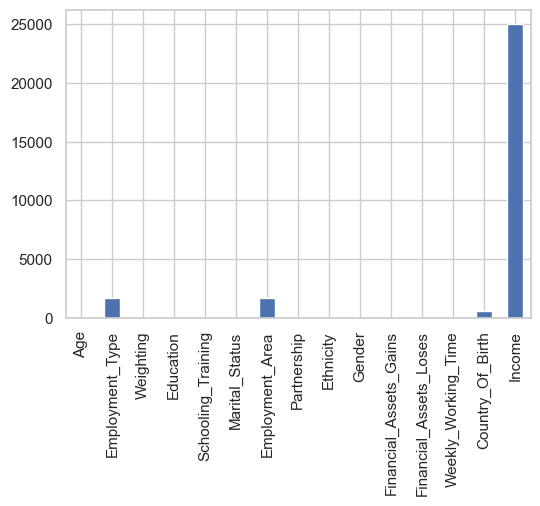

In [106]:
# Plot the missing values
plt.figure(figsize=(6,4))
df.isna().sum().plot(kind="bar")

In [107]:
df['Income'] = df['Income'].map({'<=50K': 0, '>50K': 1})

In [108]:
num_cols = ['Age','Weighting', 'Financial_Assets_Gains','Financial_Assets_Loses','Weekly_Working_Time']
cat_cols = df.drop(['Age','Weighting','Financial_Assets_Gains','Financial_Assets_Loses','Weekly_Working_Time', 'Income', 'Country_Of_Birth'], axis=1).columns.tolist()

In [109]:
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')

In [110]:
df_labeled_tmp = df[df["Income"].notna()].copy()
df_unlabeled_tmp = df[df["Income"].isna()].copy()

In [111]:
df_labeled_tmp['Income'] = df_labeled_tmp['Income'].astype(int)

## Exploratory Data Analysis

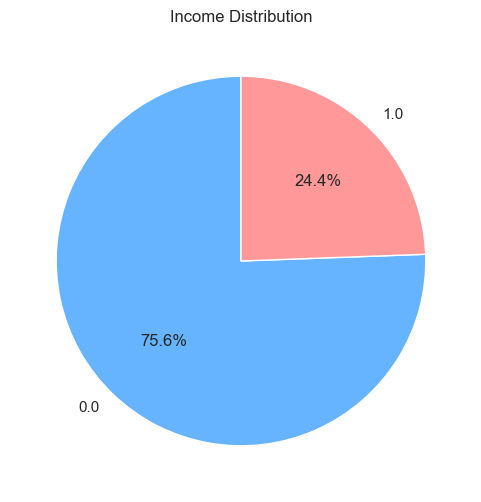

In [112]:
income_counts = df["Income"].value_counts()

# Plot pie chart
plt.figure(figsize=(6,6))
plt.pie(
    income_counts,
    labels=income_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=["#66b3ff", "#ff9999"]
)
plt.title("Income Distribution")
plt.show()

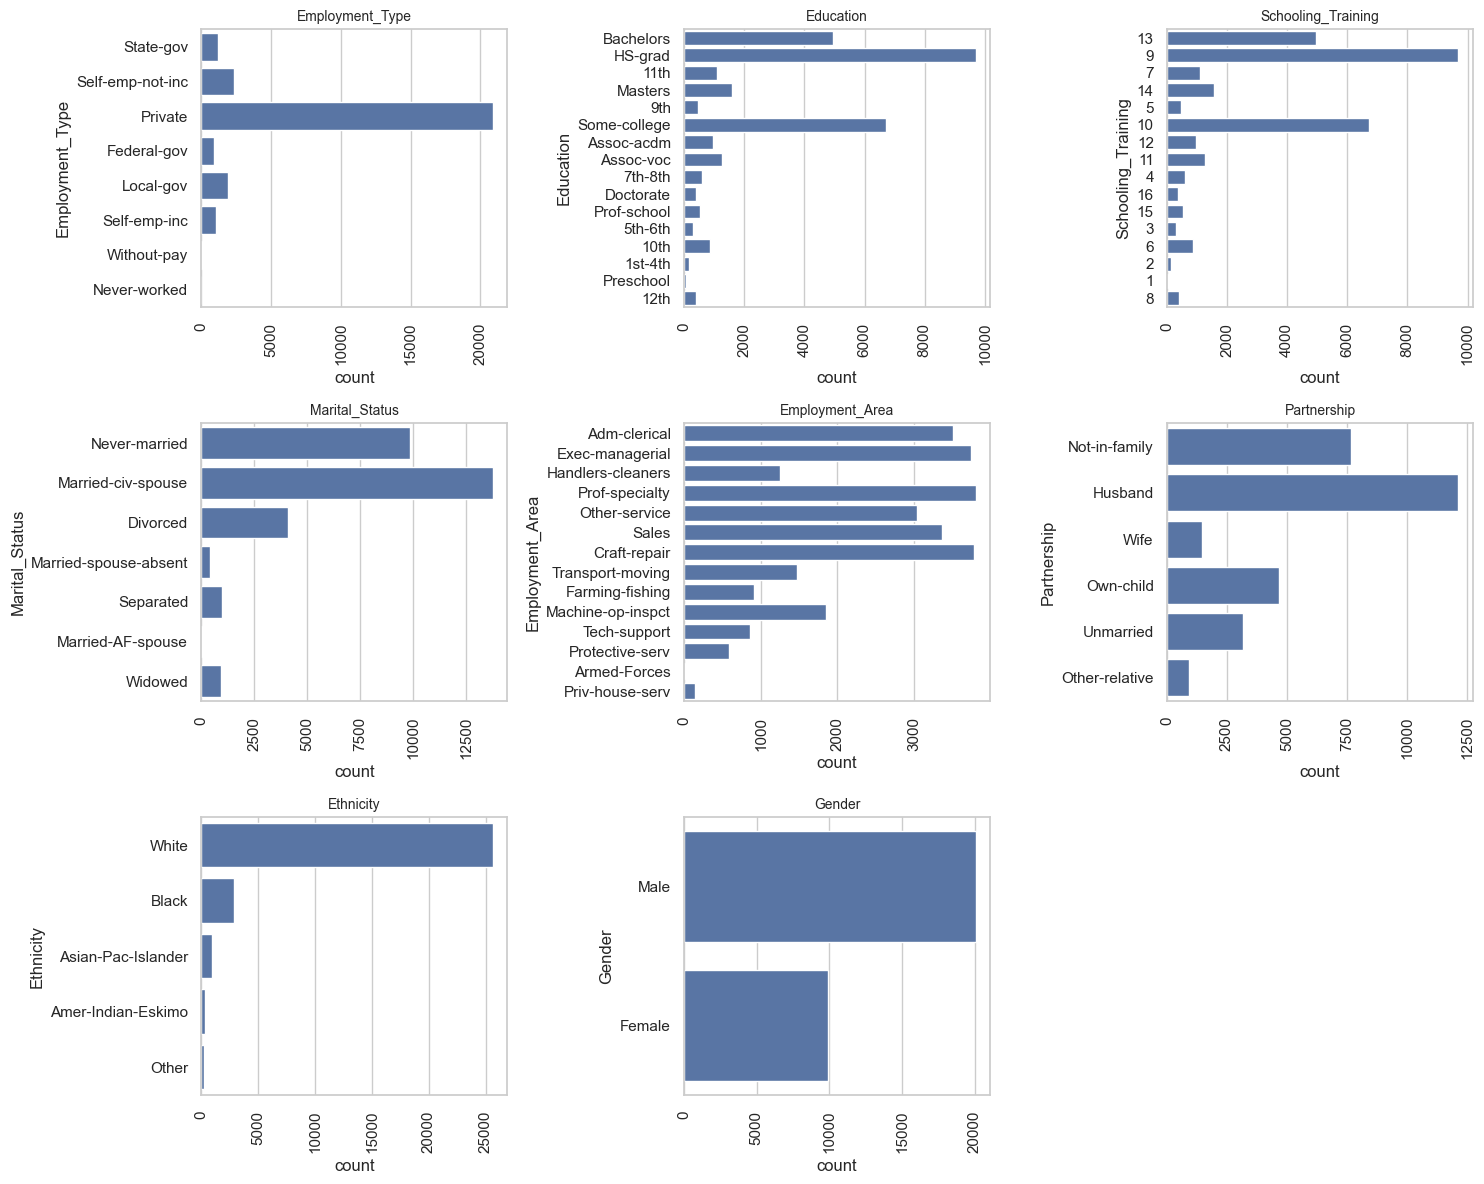

In [113]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    ax = axes[i]
    sns.countplot(data=df, y=col, ax=ax)
    ax.tick_params(axis="x", rotation=90, size=8)
    ax.set_title(f"{col}", fontsize=10)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.savefig('../docs/countplots.png')
plt.show()

### Insights
- Most categorical variables are dominated by a few classes.
- Some categories appear very infrequently and may contribute noise.

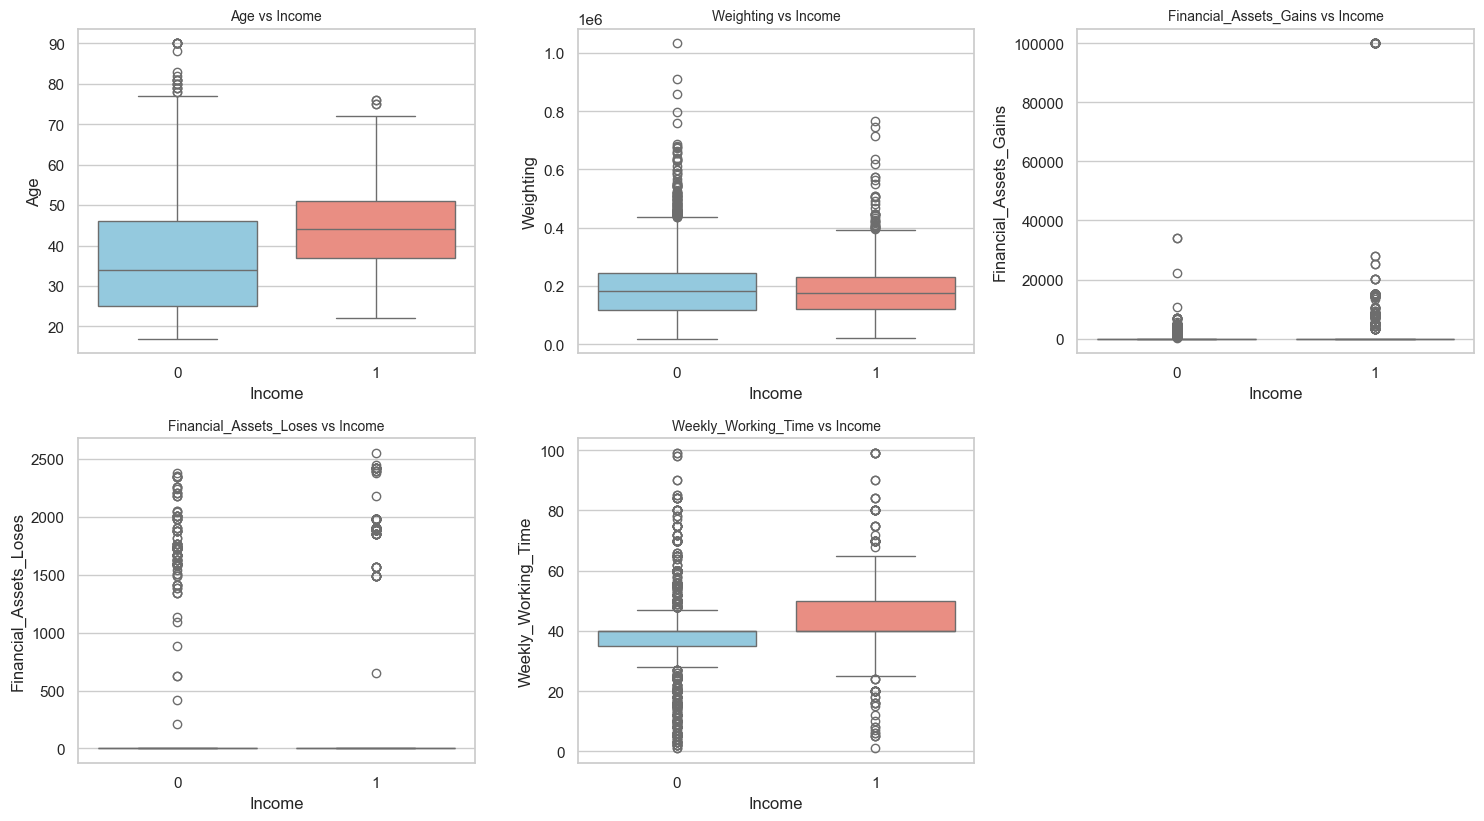

In [114]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    ax = axes[i]
    sns.boxplot(data=df_labeled_tmp, x=df_labeled_tmp["Income"].astype(str), y=col, ax=ax,
                palette={"0": "skyblue", "1": "salmon"})
    ax.set_title(f"{col} vs Income", fontsize=10)

# Remove unused axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("../docs/numplots.png")
plt.show()

### Insights
- Some numeric variables such as Financial_Assets_Gains & Financial_Assets_Losses exhibited strong skewness with extreme outliers. 
- Applying a log transformation compressed these outliers, reduced skewness, and made the distributions more comparable between income groups.

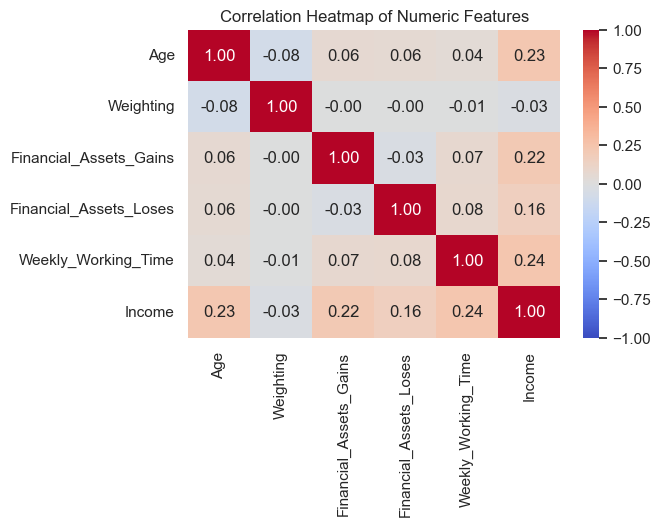

In [115]:
# Plot the Correlation Heatmap
corr = df_labeled_tmp.corr(numeric_only=True)

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

### Insights
- Numeric features don’t strongly correlate with each other.
- Numeric predictors contribute significantly but not very strongly.

## Pre-Processing

In [116]:
df['Schooling_Training'] = df['Schooling_Training'].apply(pd.to_numeric, errors='coerce')

In [117]:
df['Country_Of_Birth'].value_counts()

Country_Of_Birth
United-States                 26871
Mexico                          602
Philippines                     177
Germany                         122
Canada                          115
Puerto-Rico                     112
El-Salvador                      96
India                            94
Cuba                             87
England                          87
South                            76
Jamaica                          73
China                            68
Vietnam                          62
Dominican-Republic               62
Italy                            62
Guatemala                        60
Poland                           56
Japan                            56
Columbia                         55
Taiwan                           48
Haiti                            40
Iran                             40
Portugal                         33
Nicaragua                        32
Peru                             28
Greece                           28
France     

In [118]:
# Find top category in "Country_Of_Birth"
top_country = df['Country_Of_Birth'].value_counts().idxmax()
print("Top country:", top_country)

# Impute missing as top category
df['Country_Of_Birth'] = df['Country_Of_Birth'].fillna(top_country)

# Group all others as "Other"
df['Country_Of_Birth'] = df['Country_Of_Birth'].apply(lambda x: x if x == top_country else "Other")

print(df['Country_Of_Birth'].value_counts())

Top country: United-States
Country_Of_Birth
United-States    27410
Other             2590
Name: count, dtype: int64


In [119]:
# Find top category in "Employment_Type"
top_employment = df['Employment_Type'].value_counts().idxmax()
print("Most frequent Employment_Type:", top_employment)

# Impute missing values with that category
df['Employment_Type'] = df['Employment_Type'].fillna(top_employment)

df['Employment_Type'].isna().sum()

Most frequent Employment_Type: Private


np.int64(0)

In [120]:
df.isna().sum()

Age                           0
Employment_Type               0
Weighting                     0
Education                     0
Schooling_Training            0
Marital_Status                0
Employment_Area            1682
Partnership                   0
Ethnicity                     0
Gender                        0
Financial_Assets_Gains        0
Financial_Assets_Loses        0
Weekly_Working_Time           0
Country_Of_Birth              0
Income                    25000
dtype: int64

In [121]:
# Impute Employment Area with Decision Tree Classifier

def impute_with_tree(df, feature, target="Income", max_depth=5, random_state=42):
    """
    Impute missing values in a categorical column using a DecisionTreeClassifier
    trained on all other features.
    """
    df = df.copy()
    mask_missing = df[feature].isna()
    if mask_missing.sum() == 0:
        return df  
    
    mask_present = ~mask_missing

    # Use all other features (excluding target, Weighting, and the feature itself)
    predictors = df.drop(columns=[target, "Weighting", feature], errors="ignore")

    # One-hot encode temporarily
    X_train = pd.get_dummies(predictors.loc[mask_present], drop_first=True)
    X_missing = pd.get_dummies(predictors.loc[mask_missing], drop_first=True)

    # Align columns
    X_missing = X_missing.reindex(columns=X_train.columns, fill_value=0)

    y_train = df.loc[mask_present, feature]

    # Fit Decision Tree
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)
    clf.fit(X_train, y_train)

    # Predict for missing
    df.loc[mask_missing, feature] = clf.predict(X_missing)
    return df

# Apply imputer
special_cats = ["Employment_Area"]
for feat in special_cats:
    df = impute_with_tree(df, feat)

In [122]:
df_labeled_final = df[df["Income"].notna()]
df_unlabeled_final = df[df["Income"].isna()]

In [123]:
df_labeled_final.isna().sum()

Age                       0
Employment_Type           0
Weighting                 0
Education                 0
Schooling_Training        0
Marital_Status            0
Employment_Area           0
Partnership               0
Ethnicity                 0
Gender                    0
Financial_Assets_Gains    0
Financial_Assets_Loses    0
Weekly_Working_Time       0
Country_Of_Birth          0
Income                    0
dtype: int64

In [124]:
df_labeled_final['Income'] = df_labeled_tmp['Income'].astype(int)

In [125]:
df_labeled_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     5000 non-null   int64 
 1   Employment_Type         5000 non-null   object
 2   Weighting               5000 non-null   int64 
 3   Education               5000 non-null   object
 4   Schooling_Training      5000 non-null   int64 
 5   Marital_Status          5000 non-null   object
 6   Employment_Area         5000 non-null   object
 7   Partnership             5000 non-null   object
 8   Ethnicity               5000 non-null   object
 9   Gender                  5000 non-null   object
 10  Financial_Assets_Gains  5000 non-null   int64 
 11  Financial_Assets_Loses  5000 non-null   int64 
 12  Weekly_Working_Time     5000 non-null   int64 
 13  Country_Of_Birth        5000 non-null   object
 14  Income                  5000 non-null   int64 
dtypes: int64(

In [126]:
df_labeled_final.to_csv('../data/train.csv')
df_unlabeled_final.to_csv('../data/test.csv')

In [127]:
# Defining the predictors, target and weights
X = df_labeled_final.drop(columns=["Income", "Weighting", "Unnamed: 0"], errors="ignore")
y = df_labeled_final["Income"]
weights = df_labeled_final["Weighting"]
weights = weights / weights.mean()

In [128]:
# Train-test split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, weights, test_size=0.2, stratify=y, random_state=42
)

In [129]:
num_plain = ["Age", "Weekly_Working_Time"]
num_log   = ["Financial_Assets_Gains", "Financial_Assets_Loses"]
ord_col = ["Schooling_Training"]
cat_cols  = [c for c in X.columns if c not in num_plain +num_log + ["Weighting"]]

In [130]:
# Pre-processing Pipeline

num_plain_tf = Pipeline([
    ("scaler", StandardScaler())
])

num_log_tf = Pipeline([
    ("log1p", FunctionTransformer(np.log1p, validate=False)),
    ("scaler", StandardScaler())
])

ord_tf = Pipeline([
    ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

cat_tf = Pipeline([
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num_plain", num_plain_tf, num_plain),
    ("num_log", num_log_tf, num_log),
    ("ord", ord_tf, ord_col),
    ("cat", cat_tf, cat_cols)
])

## Logistic Regression (Baseline Model)

In [131]:
scoring = {
    "roc_auc": "roc_auc",
    "pr_auc": "average_precision"
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Baseline Logistic Regression pipeline
logreg_base = Pipeline([
    ("prep", preprocessor),
    ("model", LogisticRegression(max_iter=1000, random_state=42))       
])

cv_res, _ = evaluate_with_cv(logreg_base, X_train, y_train, w_train, model_name="LogReg (Baseline)", cv=cv)

# Refit on full training set (with same params)
logreg_base.fit(X_train, y_train, model__sample_weight=w_train)

# Final holdout evaluation
results_summary, y_prob_lr = evaluate_on_holdout(logreg_base, X_test, y_test, w_test, model_name="LogReg (Baseline)")


=== LogReg (Baseline) (Cross-Validation) ===
CV ROC-AUC: 0.893 ± 0.010
CV PR-AUC : 0.723 ± 0.029

=== LogReg (Baseline) (Holdout) ===
              precision    recall  f1-score   support

           0       0.88      0.95      0.91 779.16027905649
           1       0.76      0.58      0.66 233.89814683091208

    accuracy                           0.86 1013.0584258874021
   macro avg       0.82      0.76      0.79 1013.0584258874021
weighted avg       0.86      0.86      0.85 1013.0584258874021

ROC-AUC: 0.914
PR-AUC : 0.777
Confusion Matrix:
 [[737.15141364  42.00886542]
 [ 97.94509519 135.95305164]]


### Insights:

- Strong baseline performance: achieves high ROC-AUC (0.914) and PR-AUC (0.777), showing that it separates the classes effectively despite class imbalance.

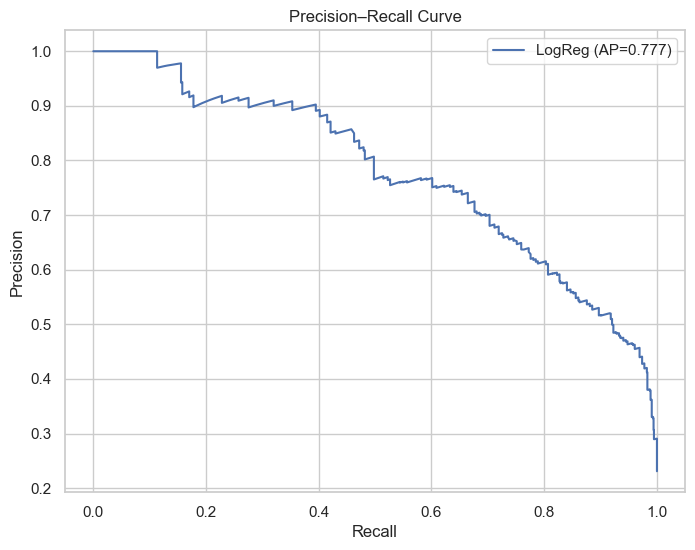

In [132]:
# === Precision–Recall curve for Logistic Regression ===
prec, rec, thres = precision_recall_curve(y_test, y_prob_lr, sample_weight=w_test)
ap = average_precision_score(y_test, y_prob_lr, sample_weight=w_test)

plt.figure(figsize=(8,6))
plt.plot(rec, prec, label=f"LogReg (AP={ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.grid(True)
plt.show()


### Insights:
- Since the positive class proportion is ~24%, the model performds much better than random.

In [133]:
thresholds = [0.3, 0.5, 0.6, 0.7, 0.9]

metrics = []
for t in thresholds:
    y_pred_custom = (y_prob_lr >= t).astype(int)
    prec = precision_score(y_test, y_pred_custom, sample_weight=w_test)
    rec = recall_score(y_test, y_pred_custom, sample_weight=w_test)
    f1 = f1_score(y_test, y_pred_custom, sample_weight=w_test)
    metrics.append({"Threshold": t, "Precision": prec, "Recall": rec, "F1": f1})

df_thresh = pd.DataFrame(metrics)
print(df_thresh.to_string(index=False))

 Threshold  Precision   Recall       F1
       0.3   0.592673 0.814890 0.686240
       0.5   0.763945 0.581249 0.660191
       0.6   0.795482 0.497817 0.612394
       0.7   0.896683 0.370460 0.524306
       0.9   0.942626 0.155607 0.267118


## Decision Trees

In [134]:
num_cols_tree = ["Age", "Financial_Assets_Gains", "Financial_Assets_Loses", "Weekly_Working_Time", "Schooling_Training"]
cat_cols_tree = [c for c in X.columns if c not in num_cols_tree + ["Weighting"]]

# Preprocessor for tree
tree_preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols_tree)
], remainder="passthrough")

In [135]:
# Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Default Decision Tree pipeline
dt_default = Pipeline([
    ("prep", tree_preprocessor),
    ("model", DecisionTreeClassifier(random_state=42))
])

# === Cross-validation on training set ===
cv_res_dt, _ = evaluate_with_cv(
    dt_default, X_train, y_train, w_train,
    model_name="Decision Tree (Default)",
    cv=cv
)

# === Refit on full training set ===
dt_default.fit(X_train, y_train, model__sample_weight=w_train)

# === Final holdout evaluation ===
results_summary, _ = evaluate_on_holdout(
    dt_default, X_test, y_test, w_test,
    model_name="Decision Tree (Default)"
)


=== Decision Tree (Default) (Cross-Validation) ===
CV ROC-AUC: 0.739 ± 0.026
CV PR-AUC : 0.457 ± 0.028

=== Decision Tree (Default) (Holdout) ===
              precision    recall  f1-score   support

           0       0.88      0.86      0.87 779.16027905649
           1       0.57      0.61      0.59 233.89814683091208

    accuracy                           0.80 1013.0584258874021
   macro avg       0.73      0.74      0.73 1013.0584258874021
weighted avg       0.81      0.80      0.81 1013.0584258874021

ROC-AUC: 0.737
PR-AUC : 0.437
Confusion Matrix:
 [[672.00038199 107.15989706]
 [ 91.69679618 142.20135065]]


### Insights:
- Overall low performance - suggests the untuned Decision Tree is too simple and doesn’t generalize well.
- Recall better, precision much lower for >50K - it catches more high-income individuals, but with many false positives.

## Hypertuning the Decision Tree (Pre-pruning)

In [136]:
# Define scorers
scoring = {
    "roc_auc": "roc_auc",
    "pr_auc": "average_precision"
}

# Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Decision Tree pipeline
dt = Pipeline([
    ("prep", tree_preprocessor),
    ("model", DecisionTreeClassifier(random_state=42))
])

# Parameter grid
param_grid = {
    "model__max_depth": [5, 10, 15, 20, 30, None],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 5, 10]
}

# GridSearchCV
grid_dt = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
    refit="pr_auc",  
    n_jobs=-1,
    verbose=2
)

# Fit with sample weights
grid_dt.fit(X_train, y_train, model__sample_weight=w_train.to_numpy())

# CV results (best mean scores)
best_idx = grid_dt.best_index_
best_params = grid_dt.best_params_
best_cv_roc = grid_dt.cv_results_['mean_test_roc_auc'][best_idx]
best_cv_pr  = grid_dt.cv_results_['mean_test_pr_auc'][best_idx]

print("\n=== Decision Tree CV Results ===")
print("Best Params:", best_params)
print("Best CV ROC-AUC:", best_cv_roc)
print("Best CV PR-AUC :", best_cv_pr)

# Store CV metrics in results_summary
results_summary["Decision Tree (Tuned)"] = {
    "CV ROC-AUC": best_cv_roc,
    "CV PR-AUC": best_cv_pr
}

# Holdout evaluation with best model
best_dt = grid_dt.best_estimator_
results_summary, _ = evaluate_on_holdout(
    best_dt, X_test, y_test, w_test, model_name="Decision Tree (Tuned)"
)

Fitting 5 folds for each of 54 candidates, totalling 270 fits

=== Decision Tree CV Results ===
Best Params: {'model__max_depth': 30, 'model__min_samples_leaf': 10, 'model__min_samples_split': 2}
Best CV ROC-AUC: 0.8690579853691791
Best CV PR-AUC : 0.7167332774801791

=== Decision Tree (Tuned) (Holdout) ===
              precision    recall  f1-score   support

           0       0.89      0.88      0.89 779.16027905649
           1       0.63      0.65      0.64 233.89814683091208

    accuracy                           0.83 1013.0584258874021
   macro avg       0.76      0.77      0.76 1013.0584258874021
weighted avg       0.83      0.83      0.83 1013.0584258874021

ROC-AUC: 0.886
PR-AUC : 0.733
Confusion Matrix:
 [[688.54667591  90.61360315]
 [ 82.01089427 151.88725256]]


### Insights:
- The model identifies more high-income individuals while keeping false positives under control.
- The optimal parameters allowed a deep tree (max_depth=30) while regularizing with larger leaf sizes (min_samples_leaf=10), preventing overfitting and capturing complex feature interactions.

## Random Forest

In [137]:
# Random Forest pipeline
rf = Pipeline([
    ("prep", tree_preprocessor),
    ("model", RandomForestClassifier(
        random_state=42,
        n_jobs=-1
    ))
])

# Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# === Cross-validation on training set ===
cv_res_rf, _ = evaluate_with_cv(
    rf, X_train, y_train, w_train,
    model_name="Random Forest",
    cv=cv
)

# === Refit on full training set ===
rf.fit(X_train, y_train, model__sample_weight=w_train)

# === Final holdout evaluation ===
results_summary, y_prob_rf = evaluate_on_holdout(
    rf, X_test, y_test, w_test,
    model_name="Random Forest"
)


=== Random Forest (Cross-Validation) ===
CV ROC-AUC: 0.888 ± 0.013
CV PR-AUC : 0.726 ± 0.024

=== Random Forest (Holdout) ===
              precision    recall  f1-score   support

           0       0.87      0.91      0.89 779.16027905649
           1       0.66      0.56      0.61 233.89814683091208

    accuracy                           0.83 1013.0584258874021
   macro avg       0.77      0.74      0.75 1013.0584258874021
weighted avg       0.82      0.83      0.83 1013.0584258874021

ROC-AUC: 0.892
PR-AUC : 0.703
Confusion Matrix:
 [[710.92372065  68.2365584 ]
 [101.82776656 132.07038027]]


### Insights:
- CV and holdout scores are very consistent, showing the model generalizes reasonably well without tuning.
- The Random Forest achieved robust performance (ROC-AUC = 0.892, PR-AUC = 0.703), consistently strong across cross-validation and holdout.

## Random Forest Hypertuning

In [138]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Random Forest pipeline (with preprocessing)
rf_tuned = Pipeline([
    ("prep", tree_preprocessor),
    ("model", RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Hyperparameter grid
param_grid_rf = {
    "model__n_estimators": [100, 200],        # number of trees
    "model__max_depth": [None, 10, 15, 20],   # limit depth
    "model__min_samples_split": [2, 5, 10],       # min samples to split
    "model__min_samples_leaf": [1, 2, 5]      # min samples per leaf
}

# GridSearchCV
grid_rf = GridSearchCV(
    estimator=rf_tuned,
    param_grid=param_grid_rf,
    cv=cv,
    scoring={"roc_auc": "roc_auc", "pr_auc": "average_precision"},
    refit="pr_auc",
    n_jobs=-1,
    verbose=2
)

# Fit with sample weights
grid_rf.fit(X_train, y_train, model__sample_weight=w_train.to_numpy())

# Best CV results
best_idx = grid_rf.best_index_
best_params = grid_rf.best_params_
best_cv_roc = grid_rf.cv_results_['mean_test_roc_auc'][best_idx]
best_cv_pr  = grid_rf.cv_results_['mean_test_pr_auc'][best_idx]

print("\n=== Random Forest CV Results ===")
print("Best Params:", best_params)
print("Best CV ROC-AUC:", best_cv_roc)
print("Best CV PR-AUC :", best_cv_pr)

# Store CV metrics
results_summary["Random Forest (Tuned)"] = {
    "CV ROC-AUC": best_cv_roc,
    "CV PR-AUC": best_cv_pr
}

# Holdout evaluation with best model
best_rf = grid_rf.best_estimator_
results_summary, y_prob_rf = evaluate_on_holdout(
    best_rf, X_test, y_test, w_test,
    model_name="Random Forest (Tuned)"
)

Fitting 5 folds for each of 72 candidates, totalling 360 fits

=== Random Forest CV Results ===
Best Params: {'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best CV ROC-AUC: 0.9082669415745231
Best CV PR-AUC : 0.7826206359142128

=== Random Forest (Tuned) (Holdout) ===
              precision    recall  f1-score   support

           0       0.87      0.97      0.92 779.16027905649
           1       0.82      0.52      0.64 233.89814683091208

    accuracy                           0.86 1013.0584258874021
   macro avg       0.85      0.74      0.78 1013.0584258874021
weighted avg       0.86      0.86      0.85 1013.0584258874021

ROC-AUC: 0.922
PR-AUC : 0.801
Confusion Matrix:
 [[752.89297259  26.26730646]
 [111.71093384 122.18721299]]


### Insights
- Precision vs. recall trade-off for >50K: Precision = 0.82 → when the model predicts >50K, it’s correct 82% of the time.
                                           Recall = 0.52 → it still misses nearly half of the true >50K earners.

This is consistent with the threshold choice 0.6(favoring precision). 

In [139]:
df_results = pd.DataFrame(results_summary).T.round(3)
print("\n=== Final Comparison Table ===")
print(df_results)


=== Final Comparison Table ===
                         CV ROC-AUC  CV PR-AUC  Holdout ROC-AUC  \
LogReg (Baseline)             0.893      0.723            0.914   
Decision Tree (Default)       0.739      0.457            0.737   
Decision Tree (Tuned)         0.869      0.717            0.886   
Random Forest                 0.888      0.726            0.892   
Random Forest (Tuned)         0.908      0.783            0.922   

                         Holdout PR-AUC  
LogReg (Baseline)                 0.777  
Decision Tree (Default)           0.437  
Decision Tree (Tuned)             0.733  
Random Forest                     0.703  
Random Forest (Tuned)             0.801  


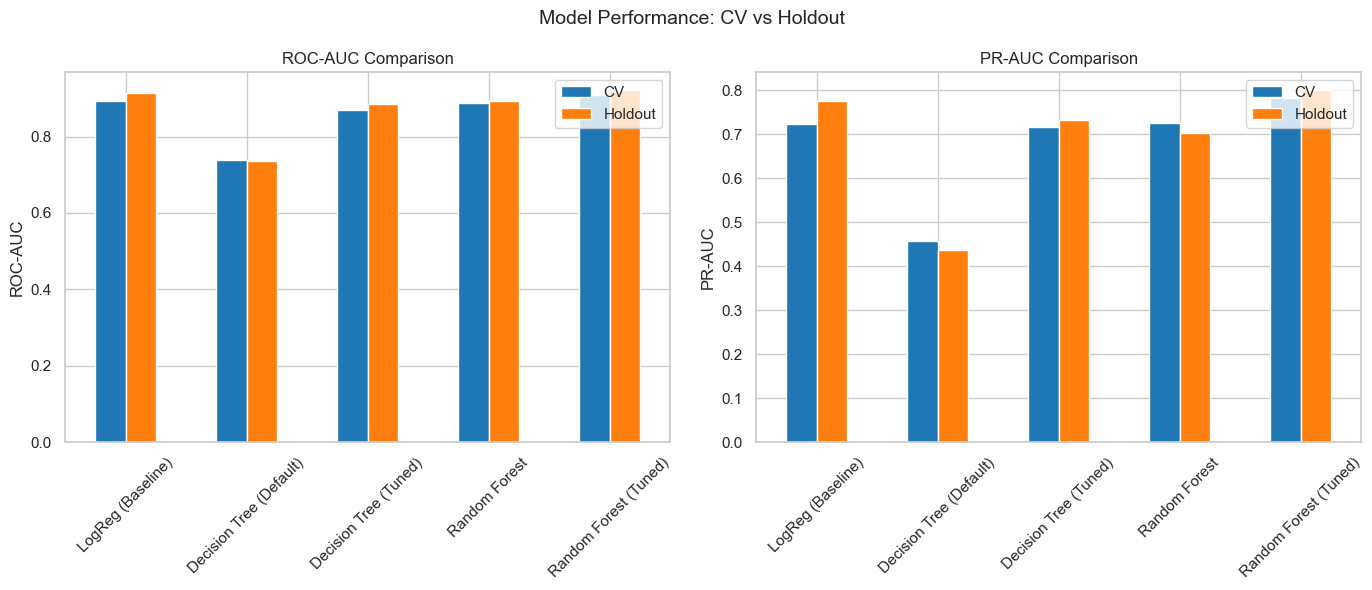

In [140]:
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=False)

colors = ["#1f77b4", "#ff7f0e"]  

# --- ROC-AUC ---
df_results[["CV ROC-AUC", "Holdout ROC-AUC"]].plot(
    kind="bar", ax=axes[0], color=colors, rot=45
)
axes[0].set_title("ROC-AUC Comparison")
axes[0].set_ylabel("ROC-AUC")
axes[0].legend(["CV", "Holdout"])

# --- PR-AUC ---
df_results[["CV PR-AUC", "Holdout PR-AUC"]].plot(
    kind="bar", ax=axes[1], color=colors, rot=45
)
axes[1].set_title("PR-AUC Comparison")
axes[1].set_ylabel("PR-AUC")
axes[1].legend(["CV", "Holdout"])

plt.suptitle("Model Performance: CV vs Holdout", fontsize=14)
plt.tight_layout()
plt.show()


## Conclusion

Among all models, the tuned Random Forest achieved the best results (ROC-AUC = 0.922, PR-AUC = 0.801), outperforming Logistic Regression and Decision Trees. Logistic Regression remained a strong baseline, while the tuned Decision Tree showed improvements but could not match the ensemble’s robustness. This confirms that ensemble methods with proper tuning provide the most reliable performance for this income classification task.

## Fitting the best model

In [141]:
# Final Model Training on ALL labeled data

final_model = grid_rf.best_estimator_

final_model.fit(X, y, model__sample_weight=weights)

,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [142]:
X_unlabeled = df_unlabeled_final.drop(columns=["Income", "Weighting"], errors="ignore")
y_proba_unlabeled = final_model.predict_proba(X_unlabeled)[:, 1]
threshold = 0.6
y_pred_unlabeled = (y_proba_unlabeled >= threshold).astype(int)

# Output DataFrame
out_unlabeled = df_unlabeled_final.copy()
out_unlabeled["Predicted_Label"] = np.where(y_pred_unlabeled == 1, ">50K", "<=50K")
out_unlabeled["Predicted_Prob"] = y_proba_unlabeled

# Save to CSV
out_unlabeled.to_csv("../results/income_predictions.csv", index=False)